In [6]:
# IF YOU WANT TO RUN QDRANT IN DOCKER, UNCOMMENT THIS LINE
# !docker run -d -p 6333:6333 qdrant/qdrant

In [8]:
import nest_asyncio
nest_asyncio.apply()

import warnings
import nest_asyncio

import os
import getpass

USE_DOCKER = False  # If you use a Docker container for Qdrant vector database, set this to True. Otherwise, set it to False.
USE_LANGSMITH = False

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

if USE_LANGSMITH:
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter Your LangChain API Key: ")
    os.environ["LANGCHAIN_TRACING_V2"] = 'true'
    os.environ["LANGSMITH_PROJECT"] = 'AIE4-E2E-RAG-WITH-FINETUNED-EMBEDDINGS-AND-DIFFERENT-CHUNKINGS'

## 👩‍💻 Task 1: Dealing with the Data

##### 🤗 Obtain an SDG Dataset for Experimentation

In [2]:
# PDF file used to determine the best chunking strategy
from langchain_community.document_loaders import PyMuPDFLoader
path='pdfs/Artificial Intelligence Risk Management Framework.pdf'
documents = PyMuPDFLoader(file_path=path).load()


# Polish the comment
import pickle
from modules.rag_chains import get_get_Q_C_A_triplets

if os.path.exists("datasets/chunking_strategies/q_c_a_triplets_for_evaluating_chunkers.pkl"):
    with open("datasets/chunking_strategies/q_c_a_triplets_for_evaluating_chunkers.pkl", "rb") as f:
        q_c_a_triplets_for_evaluating_chunkers = pickle.load(f)
else:
    os.makedirs("datasets/chunking_strategies", exist_ok=True)
    q_c_a_triplets_for_evaluating_chunkers = get_get_Q_C_A_triplets(documents = documents, n_questions_per_document = 2)

    with open("datasets/chunking_strategies/q_c_a_triplets_for_evaluating_chunkers.pkl", "wb") as f:
        pickle.dump(q_c_a_triplets_for_evaluating_chunkers, f)


SHOW_SAMPLE = True
if SHOW_SAMPLE:
    import random
    print(f"dataset size: {len(q_c_a_triplets_for_evaluating_chunkers)}")
    print("-"*50)
    idx = random.randint(0, len(q_c_a_triplets_for_evaluating_chunkers)-1)
    for key in q_c_a_triplets_for_evaluating_chunkers[idx]:
        print(f"[{key}] -> {q_c_a_triplets_for_evaluating_chunkers[idx][key].strip()}\n")


dataset size: 128
--------------------------------------------------
[question] -> What are some potential risks associated with the use of personal data in GAI system training?

[contexts] -> 7 
unethical behavior. Text-to-image models also make it easy to create images that could be used to 
promote dangerous or violent messages. Similar concerns are present for other GAI media, including 
video and audio. GAI may also produce content that recommends self-harm or criminal/illegal activities.  
Many current systems restrict model outputs to limit certain content or in response to certain prompts, 
but this approach may still produce harmful recommendations in response to other less-explicit, novel 
prompts (also relevant to CBRN Information or Capabilities, Data Privacy, Information Security, and 
Obscene, Degrading and/or Abusive Content). Crafting such prompts deliberately is known as 
“jailbreaking,” or, manipulating prompts to circumvent output controls. Limitations of GAI systems

##### 🤗 Upload the dataset to LangSmith

In [3]:
from modules.langsmith_datasets import push_datapoints

dataset_name = 'AIE4-Midterm-ChunkingStrategies'

push_datapoints(
    data=q_c_a_triplets_for_evaluating_chunkers[:30],
    input_keys=['context', 'question'],
    output_keys=['answer'],
    dataset_name=dataset_name,
    description="2 questions per page on 'Artificial Intelligence Risk Management Framework.pdf'.",
    create_new=False,  # If True, it will delete the existing dataset and create a new one.
)


Dataset(name='AIE4-Midterm-ChunkingStrategies', description="2 questions per page on 'Artificial Intelligence Risk Management Framework.pdf'.", data_type=<DataType.kv: 'kv'>, id=UUID('e5a6738d-eb1f-44a1-8826-e8cf4bfbf945'), created_at=datetime.datetime(2024, 9, 24, 12, 43, 7, 352144, tzinfo=datetime.timezone.utc), modified_at=datetime.datetime(2024, 9, 24, 12, 43, 7, 352144, tzinfo=datetime.timezone.utc), example_count=30, session_count=29, last_session_start_time=datetime.datetime(2024, 9, 26, 7, 22, 52, 708323), inputs_schema=None, outputs_schema=None)

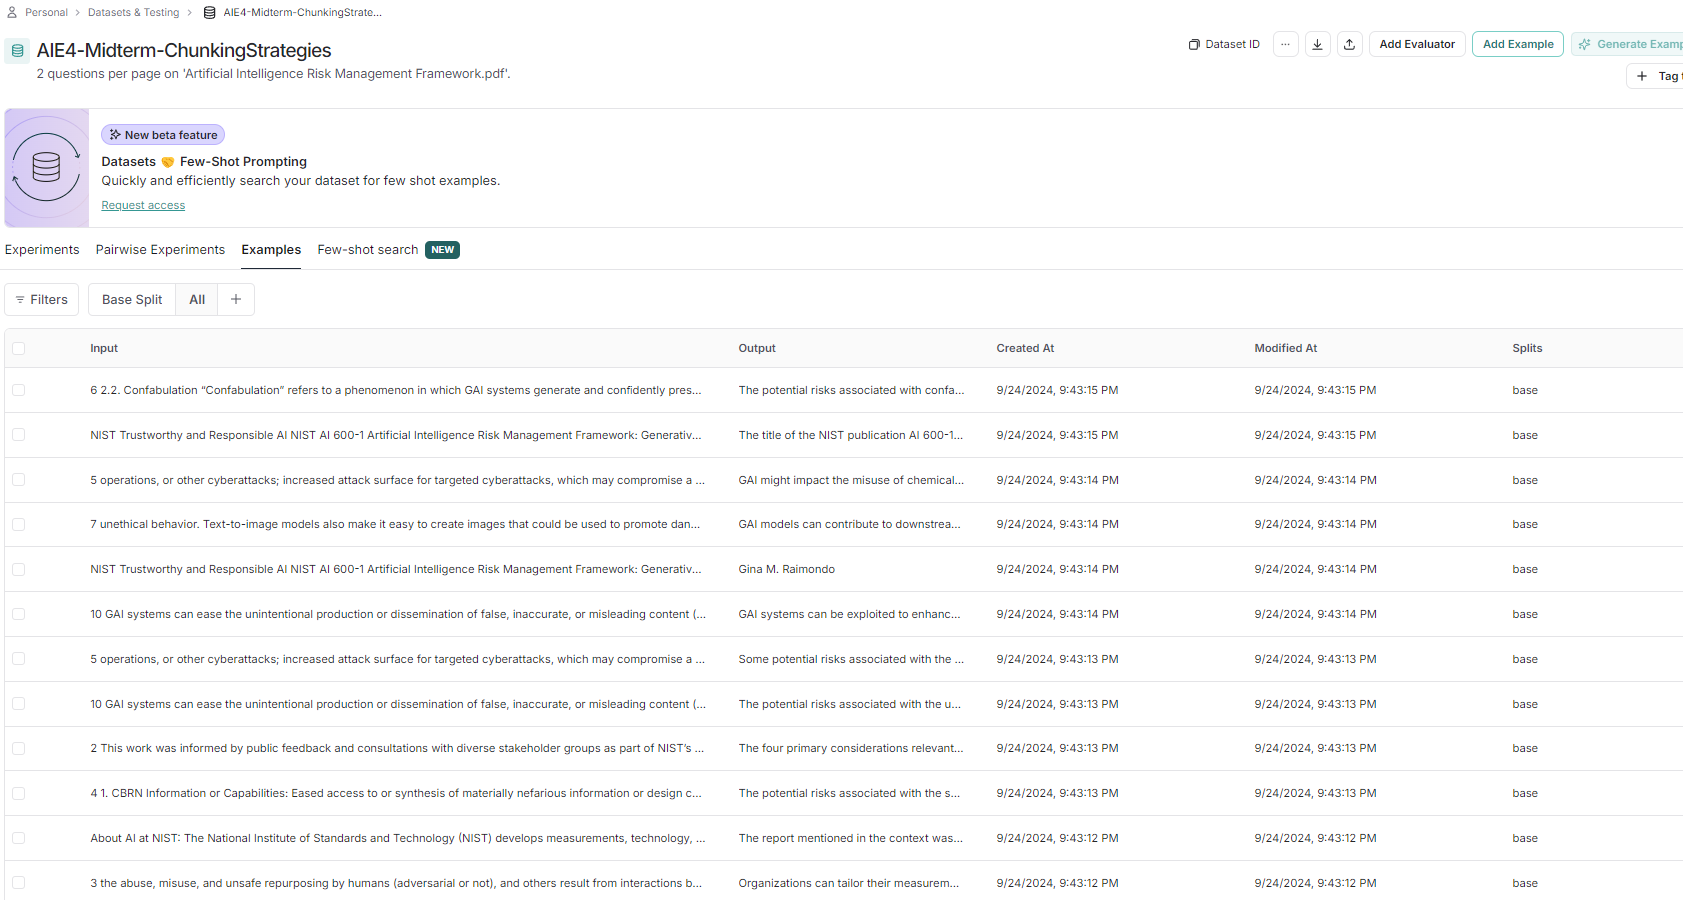

##### 🤗 Define Candidate Chunkers

In [4]:
chunking_strategies = ['recursive', 'semantic']

# Hyperparameters for each chunkers
# 1) Recursive chunker: chunk_size and chunk_overlap
recursive_chunking_hyperparameters = {
    'chunk_sizes': (200, 500, 1000),
    'chunk_overlaps': (0, 0.1, 0.2),
}

# 2) Semantic chunker:  buffer_size and breakpoint_threshold_amounts
semantic_chunking_hyperparameters = {
    'buffer_sizes': (1, 2),
    'breakpoint_threshold_amounts': (90, 95),
}

# Get each chunker
from modules.chunker import Chunker
chunkers = {}
for chunk_size in recursive_chunking_hyperparameters['chunk_sizes']:
    for chunk_overlap in recursive_chunking_hyperparameters['chunk_overlaps']:
        chunkers[f'recursive: size {chunk_size} overlap {chunk_overlap}'] = Chunker('recursive', recursive_chunking_config=dict(chunk_size=chunk_size, chunk_overlap=chunk_overlap), verbose=False)
for buffer_size in semantic_chunking_hyperparameters['buffer_sizes']:
    for breakpoint_threshold_amount in semantic_chunking_hyperparameters['breakpoint_threshold_amounts']:
        chunkers[f'semantic: buffer {buffer_size} threshold {breakpoint_threshold_amount}'] = Chunker('semantic', semantic_chunking_config=dict(buffer_size=buffer_size, breakpoint_threshold_amount=breakpoint_threshold_amount), verbose=False)

SHOW_SAMPLE = False
if SHOW_SAMPLE:
    for i, chunker in enumerate(chunkers):
        print(f"Chunker {i}-> {chunker}")

##### 🤗 Organize collections for each chunker

In [5]:
from modules.vector_stores import get_qdrant_vector_store_from_documents, get_existing_qdrant_vector_store_collection_names
from langchain_openai.embeddings import OpenAIEmbeddings
from tqdm.notebook import tqdm

chunks = {}
for chunker_name in tqdm(chunkers):
    if 'recursive' in chunker_name:
        collection_name = f"recursively_chunked_nodes_{chunker_name.split('recursive:')[1].strip().replace(' ', '_')}"        
    else:
        collection_name = f"semantically_chunked_nodes_{chunker_name.split('semantic:')[1].strip().replace(' ', '_')}"
    
    if collection_name not in get_existing_qdrant_vector_store_collection_names():
        if os.path.exists(f"documents/chunking_strategies/chunks_{chunker_name}.pkl"):
            with open(f"documents/chunking_strategies/chunks_{chunker_name}.pkl", "rb") as f:
                chunks = pickle.load(f) 
        else:
            os.makedirs("documents/chunking_strategies", exist_ok=True)
            chunks = chunkers[chunker_name].split_documents(
                documents = documents,
                verbose = False
            )
            with open(f"documents/chunking_strategies/chunks_{chunker_name}.pkl", "wb") as f:
                pickle.dump(chunks, f)

        get_qdrant_vector_store_from_documents(
            documents = chunks,
            embedding = OpenAIEmbeddings(model='text-embedding-3-small'),
            collection_name = collection_name,
            in_memory = not USE_DOCKER,  # If you want to keep the vector store in memory, set it to True
            docker_container_port ="6333",
        )    


  0%|          | 0/13 [00:00<?, ?it/s]

##### 🤗 13 Chunkers -> 13 Collections -> 13 Retrievers

In [6]:
from modules.vector_stores import get_existing_qdrant_vector_store_collection_names, get_qdrant_vector_store_from_existing_collection

retrievers = {}
for collection_name in get_existing_qdrant_vector_store_collection_names(docker_container_port="6333"):
    if collection_name.startswith('recursively_chunked_nodes') or collection_name.startswith('semantically_chunked_nodes'):
        retrievers[collection_name] = get_qdrant_vector_store_from_existing_collection(
            collection_name = collection_name,
            embedding = OpenAIEmbeddings(model='text-embedding-3-small'),
            in_memory =not USE_DOCKER,  
            docker_container_port="6333",
        ).as_retriever()

SHOW_SAMPLE = True
if SHOW_SAMPLE:
    import random
    idx = random.randint(0, len(retrievers)-1)
    query = "What are the potential risks associated with confabulations in GAI systems, particularly in real-world applications like healthcare?"
    for i, retriever in enumerate(retrievers):
        if i == idx:
            print(f"Retriever {i}-> {retriever}")
            print(f"Query: {query}")
            print(f"Relevant context:\n{retrievers[retriever].invoke(query)}")
            break

Retriever 5-> recursively_chunked_nodes_size_500_overlap_0.2
Query: What are the potential risks associated with confabulations in GAI systems, particularly in real-world applications like healthcare?
Relevant context:
[Document(metadata={'source': 'pdfs/Artificial Intelligence Risk Management Framework.pdf', 'file_path': 'pdfs/Artificial Intelligence Risk Management Framework.pdf', 'page': 9, 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'Artificial Intelligence Risk Management Framework: Generative Artificial Intelligence Profile', 'author': 'National Institute of Standards and Technology', 'subject': '', 'keywords': '', 'creator': 'Acrobat PDFMaker 24 for Word', 'producer': 'Adobe PDF Library 24.2.159', 'creationDate': "D:20240805141702-04'00'", 'modDate': "D:20240805143048-04'00'", 'trapped': '', '_id': '52e72f30-d0a9-4542-8ea3-5ed17fd11870', '_collection_name': 'recursively_chunked_nodes_size_500_overlap_0.2'}, page_content='many real-world applications, such as in healthcare, 

##### 🤗 RAG with Replaceable Retrievers

In [7]:
from modules.rag_chains import get_configurable_rag_chain
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model='gpt-4o-mini')
default_retriever = retrievers[next(iter(retrievers))]
default_rag_name = 'default_rag'

configurable_rag = get_configurable_rag_chain(
    default_retriever=default_retriever,
    default_llm=llm,
    default_rag_name=default_rag_name,
)

##### 🤗 Evaluate RAGs for each of the 13 chunkers on LangSmith

In [8]:
# 🚀 Run evaluation on LangSmith
from tqdm.notebook import tqdm
from modules.langsmith_evaluation import run_langsmith_evaluation

RERUN = True

if RERUN:
    for chunker_name in tqdm(retrievers):
        print(f"Chunker-> {chunker_name}")
        retriever = retrievers[chunker_name]
        config = {
            'configurable' : {'retriever': retrievers[next(iter(retrievers))], 'rag_name': 'RAG_'+chunker_name.split('_nodes_')[1]}
        }
        rag = configurable_rag

        if 'recursive' in chunker_name:
            chunk_size = chunker_name.split('_size_')[1].split('_')[0].strip()
            chunk_overlap = chunker_name.split('_overlap_')[1].strip()
            metadata = {"strategy": 'recursive', "chunk_size": chunk_size, "chunk_overlap": chunk_overlap}
        else:
            buffer_size = chunker_name.split('_buffer_')[1].split('_')[0].strip()
            breakpoint_threshold_amount = chunker_name.split('_threshold_')[1].strip()
            metadata = {"strategy": 'semantic', "buffer_size": buffer_size, "breakpoint_threshold_amount": breakpoint_threshold_amount}

        run_langsmith_evaluation(        
            dataset_name=dataset_name,
            evaluator_kinds='labeled_score_string',
            langchain_rag_chain = configurable_rag,
            config = config,
            experiment_prefix="RAG with differently chunked nodes",
            metadata=metadata
        )



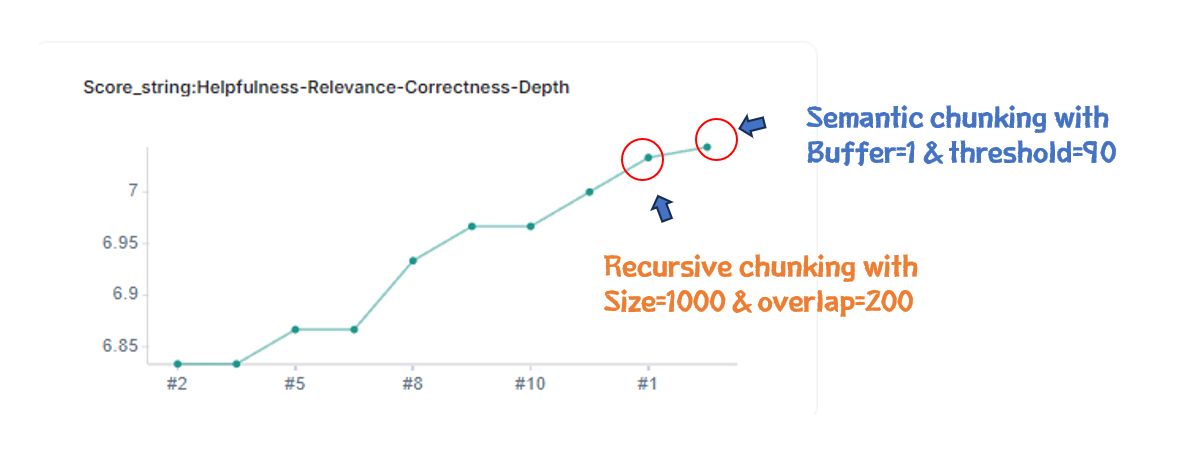

##### 🤗 Deliverables of Task 1
1. Describe the default chunking strategy that you will use.
    - I compared Recursive chunking with Semantic chunking. I selected the best parameters for each and will proceed with them.

2. Articulate a chunking strategy that you would also like to test out.
    - In the context of Dense Passage Retrieval (DPR), Recursive chunking is the de facto standard. However, new approaches, such as Semantic chunking, are gaining traction.
    - Semantic chunking divides documents based on the semantic similarity between consecutive paragraphs.
    - Semantic chunking involves two main parameters: `buffer_size` and `threshold`:
        - `buffer_size`: The number of sentences in a 'paragraph.'
        - `threshold`: If the semantic similarity exceeds this value, the Semantic chunker separates the paragraphs.
     

3. Describe how and why you made these decisions
    - Since both Recursive and Semantic chunking have their own parameter configurations, I selected a few candidates to evaluate:
        - Recursive chunking: `{'chunk_size': [200, 500, 1000], 'chunk_overlap': [0, 0.1, 0.2]}` (where `chunk_overlap` indicates the percentage of overlap).
        - Semantic chunking: `{'buffer_size': [1, 2], 'threshold': [90, 95]}`

    - I then ran evaluations on the LangSmith platform and selected the configuration with the best performance. The winners are:
        - Recursive chunking: `chunk_size=1000` and `chunk_overlap=0.2`.
        - Semantic chunking: `buffer_size=1` and `threshold=90`.

    - **Moving forward, I will use *Semantic chunking with buffer_size=1 and threshold=90* and *Recursive chunking with chunk_size=1000 and overlap=0.2* for all experiments.**
    

## 👩‍💻 Task 2: Building a Quick End-to-End Prototype
To build an end-to-end RAG (Retrieval-Augmented Generation) pipeline, we need a retriever from a vector database. The key component of a retriever is the embedding model. In this task, we will experiment with the following embedding models:

- **Open-Source Embedding Models:**
    - *Snowflake/snowflake-arctic-embed-m*
    - *all-mpnet-base-v2*

- **Reference Model:**
    - OpenAI's *text-embedding-3-small*

##### 🤗 Load Documents as the Source for Our RAGs

In [9]:
#  Load documents
from langchain_community.document_loaders import PyMuPDFLoader

path_1 = 'pdfs/Artificial Intelligence Risk Management Framework.pdf'
path_2 = 'pdfs/Blueprint-for-an-AI-Bill-of-Rights.pdf'
documents = []
for path in [path_1, path_2]:
    documents.extend(PyMuPDFLoader(file_path=path).load())

print(f"Size of documents: {len(documents)}")

Size of documents: 137


##### 🤗 Why do we need 6 retrievers?

1. **text-embedding-3-small** with vector DB from recursively chunked nodes
2. **text-embedding-3-small** with vector DB from semantically chunked nodes
3. **Snowflake/snowflake-arctic-embed-m** with vector DB from recursively chunked nodes
4. **Snowflake/snowflake-arctic-embed-m** with vector DB from semantically chunked nodes
5. **all-mpnet-base-v2** with vector DB from recursively chunked nodes
6. **all-mpnet-base-v2** with vector DB from semantically chunked nodes

In [10]:
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from modules.chunker import Chunker
from modules.vector_stores import get_qdrant_retriever_from_documents
from tqdm.notebook import tqdm
import pickle

embedding_models = {
    'openai': OpenAIEmbeddings(model='text-embedding-3-small'),
    'snowflake': HuggingFaceEmbeddings(model_name='Snowflake/snowflake-arctic-embed-m'),
    'mpnet': HuggingFaceEmbeddings(model_name='all-mpnet-base-v2')
}

chunkers = {}
for embedding_model_name, embedding_model in tqdm(embedding_models.items()):
    chunkers[f'{embedding_model_name}_recursive'] = [
        Chunker('recursive', recursive_chunking_config=dict(chunk_size=1000, chunk_overlap=200), verbose=False), None
    ]
    if os.path.exists(f"documents/e2e_rags/chunks_recursive: size 1000 overlap 0.2.pkl"):
        with open(f"documents/e2e_rags/chunks_recursive: size 1000 overlap 0.2.pkl", "rb") as f:
            chunkers[f'{embedding_model_name}_recursive'][1] = pickle.load(f)
    else:
        os.makedirs("documents/e2e_rags", exist_ok=True)
        chunkers[f'{embedding_model_name}_recursive'][1] = chunkers[f'{embedding_model_name}_recursive'][0].split_documents(
            documents = documents, verbose=False
        )
        with open(f"documents/e2e_rags/chunks_recursive: size 1000 overlap 0.2.pkl", "wb") as f:
            pickle.dump(chunkers[f'{embedding_model_name}_recursive'][1], f)
        
    
    chunkers[f'{embedding_model_name}_semantic'] = [
        Chunker('semantic', embeddings=embedding_model, semantic_chunking_config=dict(buffer_size=1, breakpoint_threshold_amount=90), verbose=False), None
    ]
    if os.path.exists(f"documents/e2e_rags/chunks_semantic: buffer 1 threshold 90-{embedding_model_name}.pkl"):
        with open(f"documents/e2e_rags/chunks_semantic: buffer 1 threshold 90-{embedding_model_name}.pkl", "rb") as f:
            chunkers[f'{embedding_model_name}_semantic'][1] = pickle.load(f)
    else:
        os.makedirs("documents/e2e_rags", exist_ok=True)
        chunkers[f'{embedding_model_name}_semantic'][1] = chunkers[f'{embedding_model_name}_semantic'][0].split_documents(
            documents = documents, verbose=False
        )
        with open(f"documents/e2e_rags/chunks_semantic: buffer 1 threshold 90-{embedding_model_name}.pkl", "wb") as f:
            pickle.dump(chunkers[f'{embedding_model_name}_semantic'][1], f)



retrievers = {}
for embedding_model_name, embedding_model in tqdm(embedding_models.items()):
    retrievers[f'{embedding_model_name}_recursive'] = get_qdrant_retriever_from_documents(
        documents = chunkers[f'{embedding_model_name}_recursive'][1],
        embedding=embedding_model,
        collection_name=f'{embedding_model_name}_recursive',
        in_memory = not USE_DOCKER,
        docker_container_port ="6333",
    )

    retrievers[f'{embedding_model_name}_semantic'] = get_qdrant_retriever_from_documents(
        documents = chunkers[f'{embedding_model_name}_semantic'][1],
        embedding=embedding_model,
        collection_name=f'{embedding_model_name}_semantic',
        in_memory = not USE_DOCKER,
        docker_container_port ="6333",
    )

SHOW_SAMPLE = True
if SHOW_SAMPLE:
    for i, retriever in enumerate(retrievers):
        print(f"Chunker {i}-> {retriever} retriever")

/home/jetlee/anaconda3/envs/midterm/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/jetlee/anaconda3/envs/midterm/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[WARGNING] Collection openai_recursive already exists. You have chosen to skip adding the documents you provided.
[WARGNING] Collection openai_semantic already exists. You have chosen to skip adding the documents you provided.
[WARGNING] Collection snowflake_recursive already exists. You have chosen to skip adding the documents you provided.
[WARGNING] Collection snowflake_semantic already exists. You have chosen to skip adding the documents you provided.
[WARGNING] Collection mpnet_recursive already exists. You have chosen to skip adding the documents you provided.
[WARGNING] Collection mpnet_semantic already exists. You have chosen to skip adding the documents you provided.
Chunker 0-> openai_recursive retriever
Chunker 1-> openai_semantic retriever
Chunker 2-> snowflake_recursive retriever
Chunker 3-> snowflake_semantic retriever
Chunker 4-> mpnet_recursive retriever
Chunker 5-> mpnet_semantic retriever


In [11]:
# Configure RAG with Replaceable Retrievers
from modules.rag_chains import get_configurable_rag_chain
from langchain_openai import ChatOpenAI

default_llm= ChatOpenAI(model='gpt-4o-mini')
default_retriever = retrievers[next(iter(retrievers))]

configurable_rag_chain = get_configurable_rag_chain(
        default_retriever=default_retriever, 
        default_llm=default_llm,
        default_rag_name = 'default_rag' 
)

# Vibe Test for All Retrievers
SHOW_SAMPLE = True

if SHOW_SAMPLE:
        inputs = {'question': "How does NIST support safe AI in line with the 2023 Executive Order?"}
        for retriever_name, retriever in retrievers.items():
                print(f"Retriever: {retriever_name}")
                config = {
                        'configurable' : {'retriever': retriever, 'rag_name': f"RAG-{retriever_name}"}
                }
                output = configurable_rag_chain.invoke(inputs, config=config)
                print(f"Q: {inputs['question']}")
                print(f"A: {output['prediction']}\n")



Retriever: openai_recursive
Q: How does NIST support safe AI in line with the 2023 Executive Order?
A: NIST supports safe AI in line with the 2023 Executive Order by developing measurements, technology, tools, and standards to ensure AI is reliable, safe, transparent, explainable, privacy-enhanced, and fair. They have established the U.S. AI Safety Institute and the AI Safety Institute Consortium to build the necessary science for safe, secure, and trustworthy AI development and use.

Retriever: openai_semantic
Q: How does NIST support safe AI in line with the 2023 Executive Order?
A: NIST supports safe AI in line with the 2023 Executive Order by developing measurements, technology, tools, and standards that promote reliable, safe, transparent, explainable, privacy-enhanced, and fair AI. They established the U.S. AI Safety Institute and the AI Safety Institute Consortium to build the science necessary for safe and trustworthy AI development and use. Additionally, NIST is creating a ris

##### 🤗 Deliverables of Task 2
1. Build a prototype and deploy to a Hugging Face Space, and create a short (< 2 min) loom video demonstrating some initial testing inputs and outputs.  🤗🤗🤗

2. How did you choose your stack, and why did you select each tool the way you did?
    - **Embedding Models**: I selected the following open-source embedding models:
        - *Snowflake/snowflake-arctic-embed-m*: This model was used during AIE4 Week 5.
        - *all-mpnet-base-v2*: A popular open-source embedding model available on Hugging Face.
    
    - **Vector Database**: I chose Qdrant as my vector database provider because it offers lightweight and user-friendly vector databases.

    - **RAG Pipeline Implementation**: I utilized LangChain's LCEL to implement end-to-end RAG pipelines, as it simplifies the development of LLM applications.

## 👩‍💻 Task 3: Creating a Golden Test Data Set

##### 🤗 Create a Golden Test Dataset Using RAGAS's TestsetGenerator

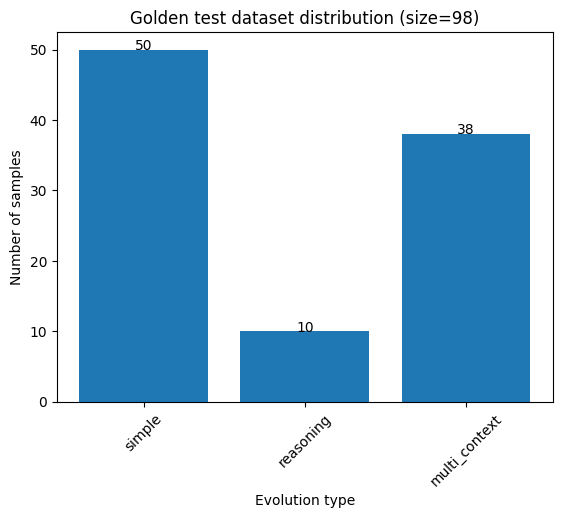

In [15]:
# 🚀 Create a golden test dataset using RAGAS's TestsetGenerator

import random
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from modules.utils import get_bar_plot



SDG_generator = TestsetGenerator.from_langchain(
    generator_llm = ChatOpenAI(model="gpt-3.5-turbo").with_config({'run_name': 'RAGAS Gerator llm'}) ,
    critic_llm =  ChatOpenAI(model="gpt-4o-mini").with_config({'run_name': 'RAGAS Critic llm'}),
    embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
) 

SDG_distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

random.shuffle(documents) # Shuffle the documents since we use only a portion of them
test_size = 100 

if os.path.exists('datasets/e2e_evaluation/golden_test_dataset_df.pkl'):
    with open('datasets/e2e_evaluation/golden_test_dataset_df.pkl', 'rb') as f:
        golden_testset = pickle.load(f)
else:   
    os.makedirs('datasets/e2e_evaluation', exist_ok=True)
    golden_testset = SDG_generator.generate_with_langchain_docs(
        test_size = test_size,
        documents = documents, 
        distributions = SDG_distributions, 
        with_debugging_logs=True,
        is_async = False
        ) 
    with open('datasets/e2e_evaluation/golden_test_dataset_df.pkl', 'wb') as f:
        pickle.dump(golden_testset, f)

     
df = golden_testset.to_pandas()
get_bar_plot(
    data = {
    'simple': len(df[df['evolution_type']=='simple']),
    'reasoning': len(df[df['evolution_type']=='reasoning']),
    'multi_context': len(df[df['evolution_type']=='multi_context'])
    },
    title = f'Golden test dataset distribution (size={len(df)})',
    xlabel='Evolution type',
    ylabel='Number of samples'
)


##### 🤗 Push the golden test dataset to LangSmith

In [16]:
from modules.langsmith_datasets import push_datapoints

input_keys=['question', 'contexts', 'evolution_type', 'metadata']
output_keys=['ground_truth']
dataset_name="AIE4-Midterm-GoldenTestDataset"
description=f"{test_size} RAGAS-generated questions on 'Artificial Intelligence Risk Management Framework.pdf' and 'Blueprint-for-an-AI-Bill-of-Rights.pdf'."

push_datapoints(
    data=df.to_dict(orient='records'),
    input_keys=input_keys,
    output_keys=output_keys,
    dataset_name=dataset_name,
    description=description,
    create_new=False,
)


Dataset(name='AIE4-Midterm-GoldenTestDataset', description="100 RAGAS-generated questions on 'Artificial Intelligence Risk Management Framework.pdf' and 'Blueprint-for-an-AI-Bill-of-Rights.pdf'.", data_type=<DataType.kv: 'kv'>, id=UUID('3d554600-b891-41cb-9ef4-ee67b81bb323'), created_at=datetime.datetime(2024, 9, 25, 17, 31, 27, 811934, tzinfo=datetime.timezone.utc), modified_at=datetime.datetime(2024, 9, 25, 17, 31, 27, 811934, tzinfo=datetime.timezone.utc), example_count=98, session_count=0, last_session_start_time=None, inputs_schema=None, outputs_schema=None)

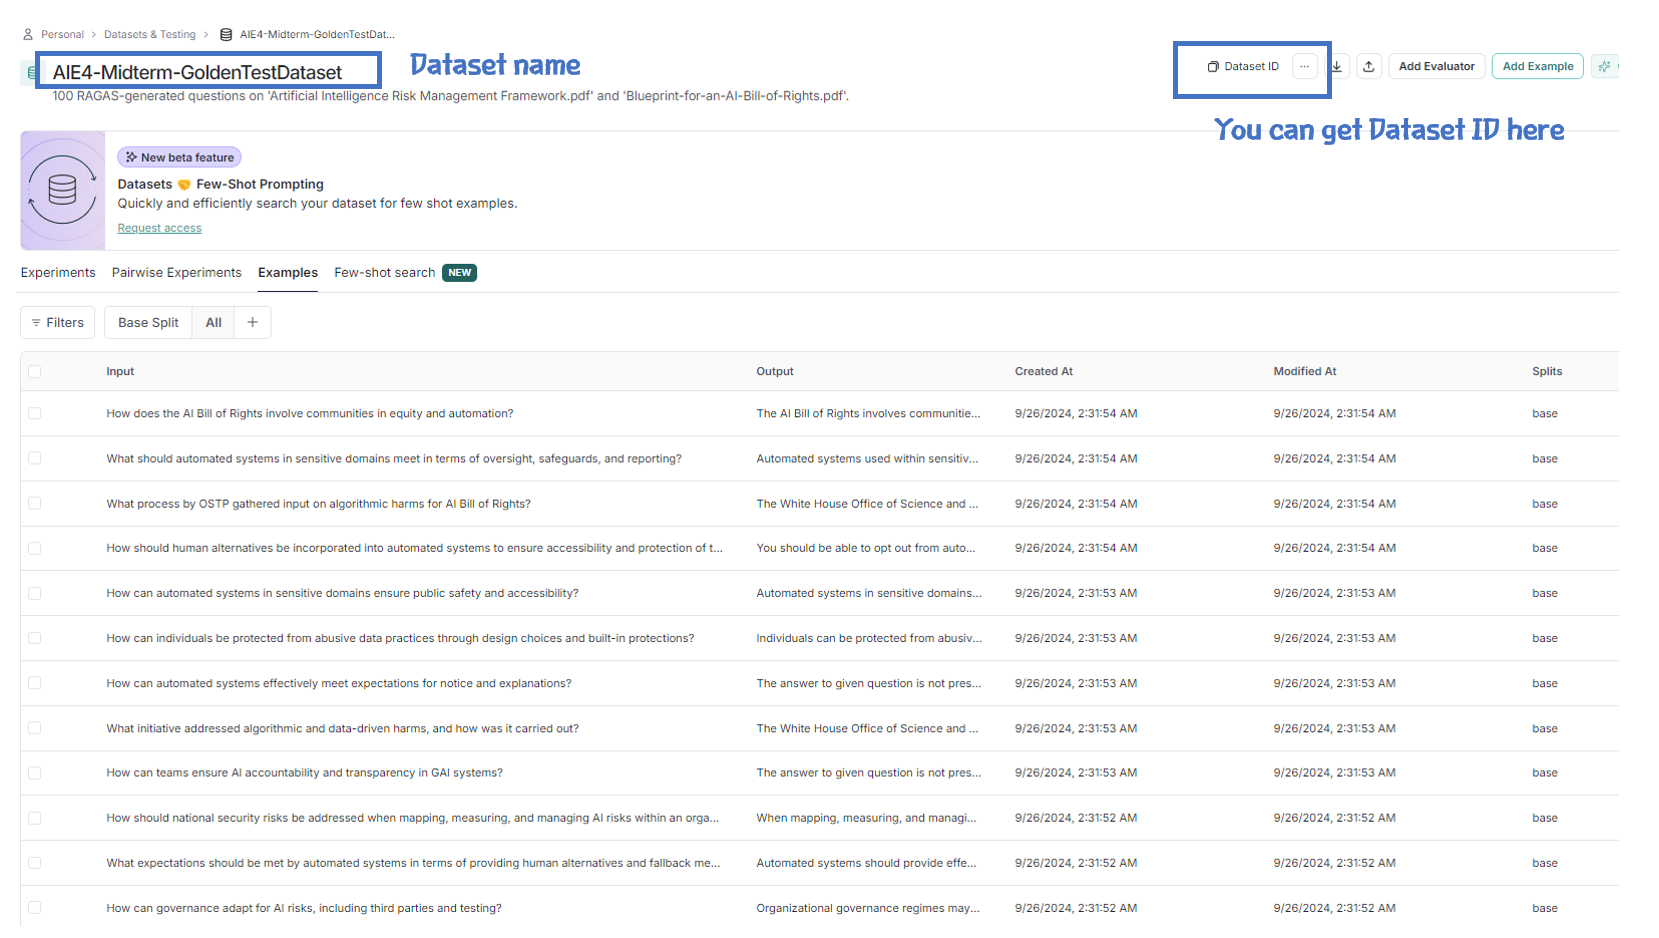

##### 🤗 Evaluate each of the e2e RAGs!

1. RAG with Retrieve with *text-embedding-3-small* and Recursive Chunking
2. RAG with Retrieve with *text-embedding-3-small* and Semantic Chunking
3. RAG with Retrieve with *Snowflake/snowflake-arctic-embed-m* and Recursive Chunking
4. RAG with Retrieve with *Snowflake/snowflake-arctic-embed-m* and Semantic Chunking
5. RAG with Retrieve with *all-mpnet-base-v2* and Recursive Chunking
6. RAG with Retrieve with *all-mpnet-base-v2* and Semantic Chunking

  0%|          | 0/6 [00:00<?, ?it/s]

/home/jetlee/workspace/MIDTERM_TEST/Cohort_AIE4/midterm/modules/utils.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(metric.keys(), rotation=45, ha='right')
/home/jetlee/workspace/MIDTERM_TEST/Cohort_AIE4/midterm/modules/utils.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(metric.keys(), rotation=45, ha='right')
/home/jetlee/workspace/MIDTERM_TEST/Cohort_AIE4/midterm/modules/utils.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(metric.keys(), rotation=45, ha='right')
/home/jetlee/workspace/MIDTERM_TEST/Cohort_AIE4/midterm/modules/utils.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

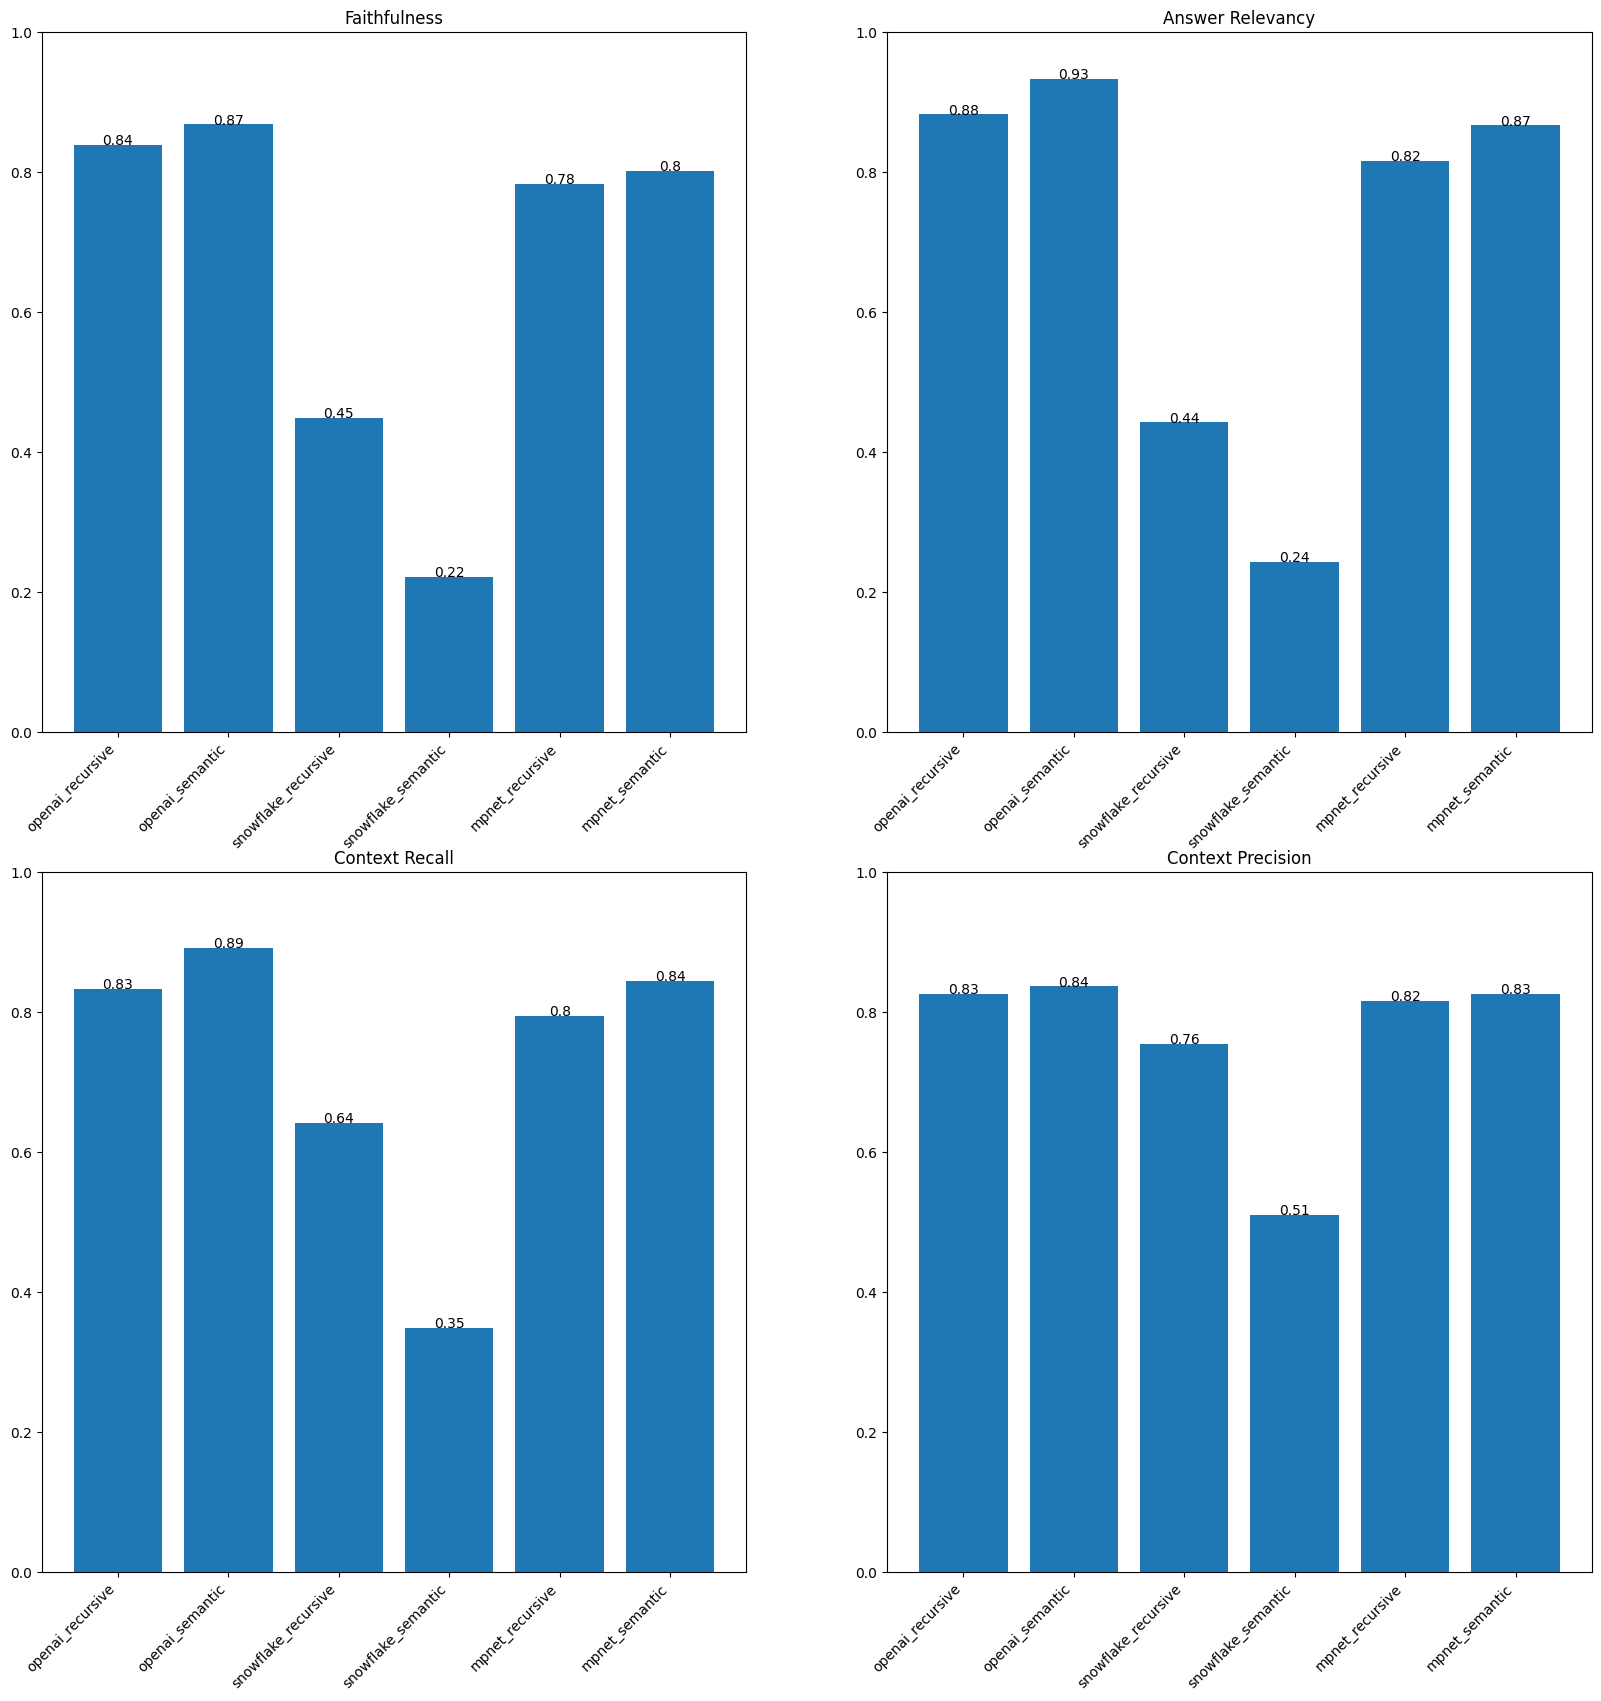

In [17]:
from langsmith import Client
from modules.ragas_evaluation import RAGAS_e2e_evalate
from tqdm.notebook import tqdm
from modules.utils import viaulaize_results

# Download the test set from LangSmith that we previously uploaded.
client = Client()
dataset_id = "3d554600-b891-41cb-9ef4-ee67b81bb323"  # 📥 [Important] Swap out for yours
testset = list(client.list_examples(dataset_id=dataset_id))
testset = [{'question':data.inputs['question'], 'ground_truth':data.outputs['ground_truth'] } for data in testset]

# Execute and evaluate each of the RAGs
ragas_results ={}
for retriever_name, retriever in tqdm(retrievers.items()):
    config = {
            'configurable' : {'retriever': retriever, 'rag_name': f"RAG-{retriever_name}"}
    }
    
    if os.path.exists(f"Results/RAGAS_before_finetuning/{retriever_name}.pkl"):
        with open(f"Results/RAGAS_before_finetuning/{retriever_name}.pkl", "rb") as f:
            result = pickle.load(f)
    else:
        os.makedirs("Results/RAGAS_before_finetuning", exist_ok=True)
        result = RAGAS_e2e_evalate(configurable_rag_chain, testset, config)
        with open(f"Results/RAGAS_before_finetuning/{retriever_name}.pkl", "wb") as f:
            pickle.dump(result, f)
    
    ragas_results[retriever_name] = result

df = viaulaize_results(ragas_results, orders = ['openai_recursive', 'openai_semantic', 'snowflake_recursive', 'snowflake_semantic', 'mpnet_recursive', 'mpnet_semantic'])

##### 🤗 Deliverables of Task 3
1. Assess your pipeline using the RAGAS framework including key metrics faithfulness, answer relevancy, context precision, and context recall. Provide a table of your output results.

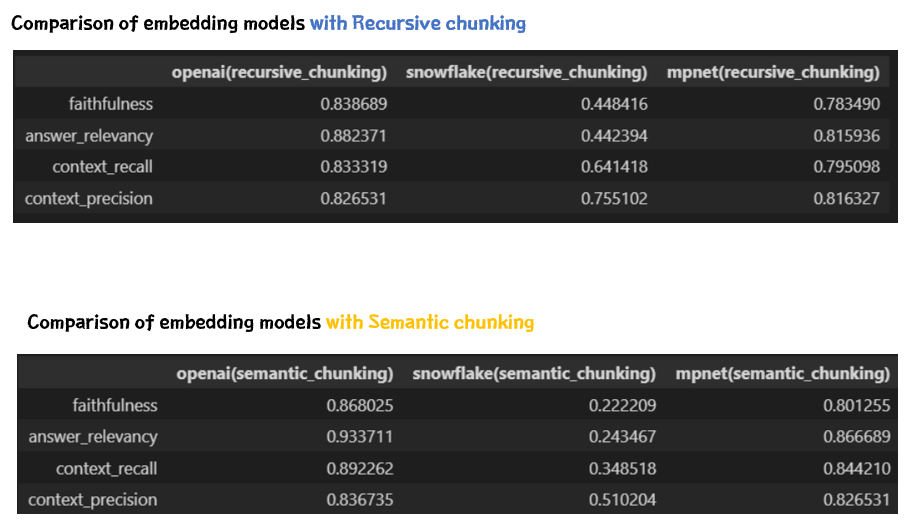

2. What conclusions can you draw about performance and effectiveness of your pipeline with this information?
    - As expected, 'OpenAI embeddings' show the best performance.
    - 'mpnet embeddings' are the second-best in terms of performance, even though 'Snowflake embeddings' and 'mpnet' have the same number of parameters.
    - For 'Snowflake embeddings', recursive chunking seems better, while semantic chunking is more promising for 'mpnet embeddings.'
    - There may be room for inprovment for each open-source models.

## 👩‍💻 Task 4: Fine-Tuning Open-Source Embeddings

##### 🤗 We need 3 finetuning datasets. Why?
1) ~~*text-embedding-3-small* and recursive chunking~~ -> We will not finetune this.
2) ~~*text-embedding-3-small* and semantic chunking~~ -> We will not finetune this.
3) *Snowflake/snowflake-arctic-embed-m* and recursive chunking
4) *Snowflake/snowflake-arctic-embed-m* and semantic chunking
5) *all-mpnet-base-v2* and recursive chunking
6) *all-mpnet-base-v2* and semantic chunking

In [18]:
# 🚀 Generate synthetic fine-tuning data required by Hugging Face's SentenceTransformer finetuning API
from modules.finetune import get_questions_and_contexts_for_SentenceTrnasformerFinetuning
import uuid

ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}
sentence_transformer_finetuning_datasets = {}


if os.path.exists(f"datasets/sentence_tr_finetuning/IR_finetune_dataset.pkl"):
    with open(f"datasets/sentence_tr_finetuning/IR_finetune_dataset.pkl", "rb") as f:
        sentence_transformer_finetuning_datasets = pickle.load(f)

else:
    os.makedirs("datasets/sentence_tr_finetuning", exist_ok=True)
    sentence_transformer_finetuning_datasets = {}
    for chunker_name, chunker in tqdm(chunkers.items()):
        if 'openai' in chunker_name: continue

        print(chunker_name)        
        random.shuffle(chunker[1])

        id_set = set()
        for document in chunker[1]:
            id = str(uuid.uuid4())
            while id in id_set:
                id = uuid.uuid4()
            id_set.add(id)
            document.metadata["id"] = id

        training_documents_size = len(chunker[1])
        training_split_size = int(training_documents_size * ratio['train'])
        val_split_size = int(training_documents_size * ratio['val'])
        test_split_size = int(training_documents_size * ratio['test'])

        training_split_documents = chunker[1][:training_split_size]
        val_split_documents = chunker[1][training_split_size:training_split_size+val_split_size]
        test_split_documents = chunker[1][training_split_size+val_split_size:]

        sentence_transformer_finetuning_datasets[chunker_name]= {}
        sentence_transformer_finetuning_datasets[chunker_name]['training'] = get_questions_and_contexts_for_SentenceTrnasformerFinetuning(split='training', documents=training_split_documents, n_questions=2)
        sentence_transformer_finetuning_datasets[chunker_name]['validation'] = get_questions_and_contexts_for_SentenceTrnasformerFinetuning(split='validation', documents=val_split_documents, n_questions=2)
        sentence_transformer_finetuning_datasets[chunker_name]['test'] = get_questions_and_contexts_for_SentenceTrnasformerFinetuning(split='test', documents=test_split_documents, n_questions=2)

    with open('datasets/sentence_tr_finetuning/IR_finetune_dataset.pkl', 'wb') as f:
        pickle.dump(sentence_transformer_finetuning_datasets, f)


sentence_transformer_finetuning_datasets.keys()

  0%|          | 0/6 [00:00<?, ?it/s]

snowflake_recursive
snowflake_semantic
mpnet_recursive
mpnet_semantic


dict_keys(['snowflake_recursive', 'snowflake_semantic', 'mpnet_recursive', 'mpnet_semantic'])

##### 🤗 Load the SentenceTransformer model and define loss functions

In [19]:
# Load two base models from Hugging Face Sentence Transformers (not using LangChain Wrapper to access model weights)
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

HF_models = {
    'snowflake': SentenceTransformer(model_name_or_path='Snowflake/snowflake-arctic-embed-m'),
    'mpnet': SentenceTransformer(model_name_or_path='all-mpnet-base-v2')
}


# Select loss function (MultipleNegativesRankingLoss wrapped by MatryoshkaLoss)
matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_losses  = {
    'snowflake':MultipleNegativesRankingLoss(HF_models['snowflake']),
    'mpnet':MultipleNegativesRankingLoss(HF_models['mpnet']),
}  
train_losses = {
    'snowflake': MatryoshkaLoss(HF_models['snowflake'], inner_train_losses['snowflake'], matryoshka_dims=matryoshka_dimensions),
    'mpnet': MatryoshkaLoss(HF_models['mpnet'], inner_train_losses['mpnet'], matryoshka_dims=matryoshka_dimensions),
}

/home/jetlee/anaconda3/envs/midterm/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


##### 🤗 Get dataloader and create evaluator for cross-validation

In [20]:
from modules.finetune import get_data_loader
from sentence_transformers.evaluation import InformationRetrievalEvaluator

# polish comment
BATCH_SIZE = 20
loders = {}
for model_name, dataset in sentence_transformer_finetuning_datasets.items():
    loders[model_name] = get_data_loader(dataset=dataset['training'], batch_size=BATCH_SIZE)

print(loders)

# Evaluator for validation during finetuning
evaluators = {}
for model_name, dataset in sentence_transformer_finetuning_datasets.items():
    corpus = dataset['validation']['corpus']
    queries = dataset['validation']['questions']
    relevant_docs = dataset['validation']['relevant_contexts']
    evaluators[model_name] = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

print(evaluators)

{'snowflake_recursive': <torch.utils.data.dataloader.DataLoader object at 0x7f974921fad0>, 'snowflake_semantic': <torch.utils.data.dataloader.DataLoader object at 0x7f9730aafe90>, 'mpnet_recursive': <torch.utils.data.dataloader.DataLoader object at 0x7f974c703b50>, 'mpnet_semantic': <torch.utils.data.dataloader.DataLoader object at 0x7f9730a3ac90>}
{'snowflake_recursive': <sentence_transformers.evaluation.InformationRetrievalEvaluator.InformationRetrievalEvaluator object at 0x7f9730a38bd0>, 'snowflake_semantic': <sentence_transformers.evaluation.InformationRetrievalEvaluator.InformationRetrievalEvaluator object at 0x7f9730a38b90>, 'mpnet_recursive': <sentence_transformers.evaluation.InformationRetrievalEvaluator.InformationRetrievalEvaluator object at 0x7f9730a3a1d0>, 'mpnet_semantic': <sentence_transformers.evaluation.InformationRetrievalEvaluator.InformationRetrievalEvaluator object at 0x7f9730a39ed0>}


##### 🤗 Let's finetune!!

In [22]:
EPOCHS = 5

RERUN = False
if RERUN:
    for model_name in loders:
        warmup_steps = int(len(loders[model_name]) * EPOCHS * 0.1)  # Stability purpose. 10% of the total number of steps
        if 'snowflake' in model_name:
            print(f"-- {model_name} --")
            HF_models['snowflake'].fit(
                train_objectives=[(loders[model_name], train_losses['snowflake'])],
                epochs=EPOCHS,
                warmup_steps=warmup_steps,
                output_path=f'finetuned_embeddings/{model_name}',
                show_progress_bar=True,
                evaluator=evaluators[model_name],
                evaluation_steps=50,
            )
        elif 'mpnet' in model_name:
            print(f"-- {model_name} --")
            HF_models['mpnet'].fit(
                train_objectives=[(loders[model_name], train_losses['mpnet'])],
                epochs=EPOCHS,
                warmup_steps=warmup_steps,
                output_path=f'finetuned_embeddings/{model_name}',
                show_progress_bar=True,
                evaluator=evaluators[model_name],
                evaluation_steps=50,
            )



Here is the capture of the results of the finetuning ('snowflake' and 'mpnet' in order)

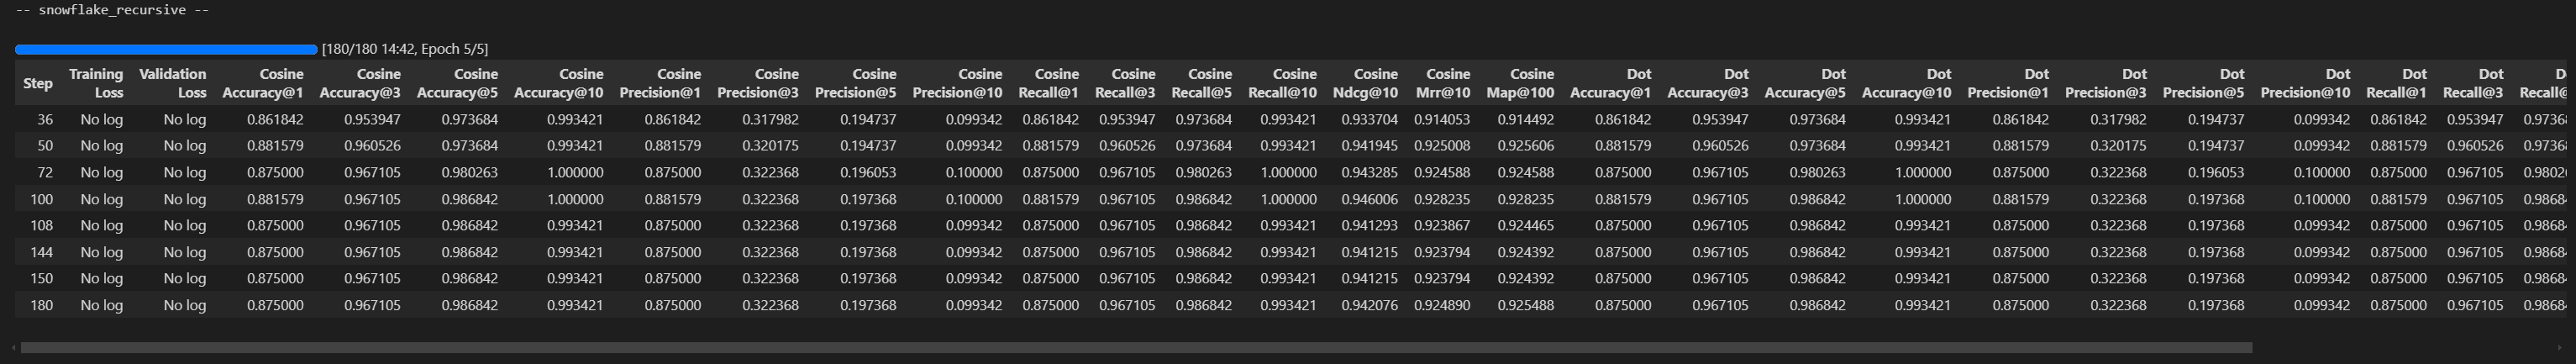

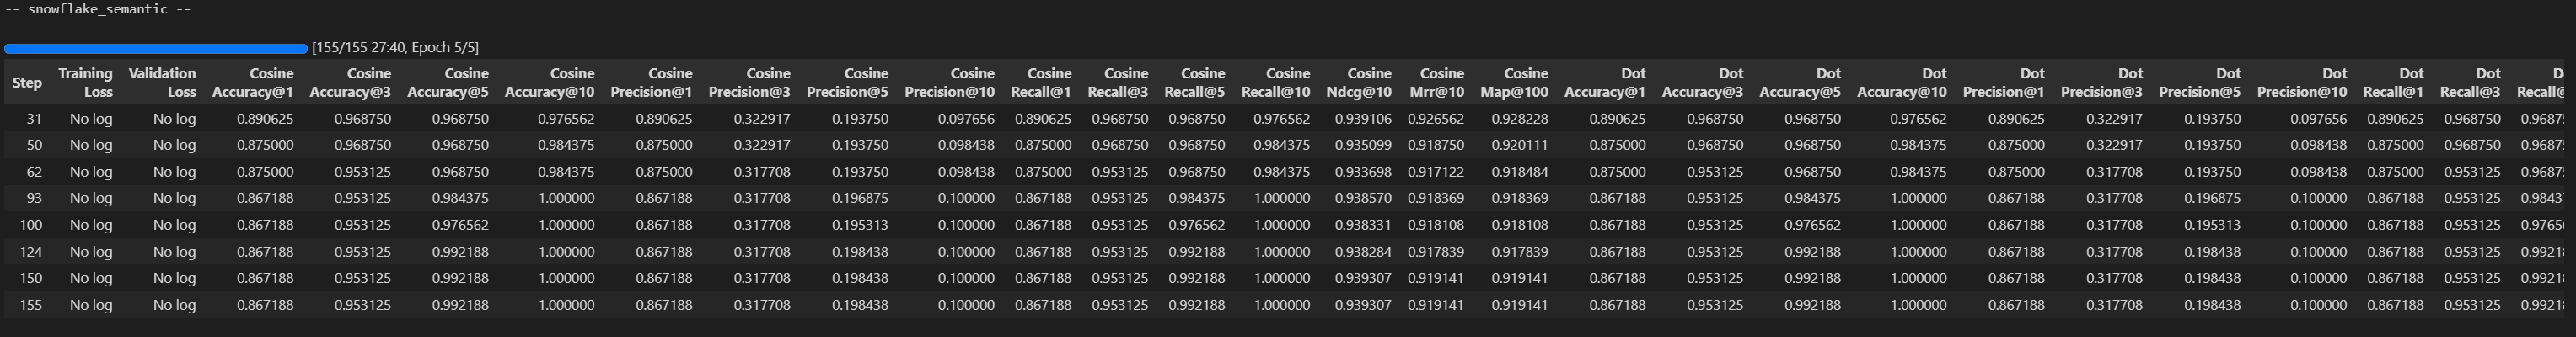

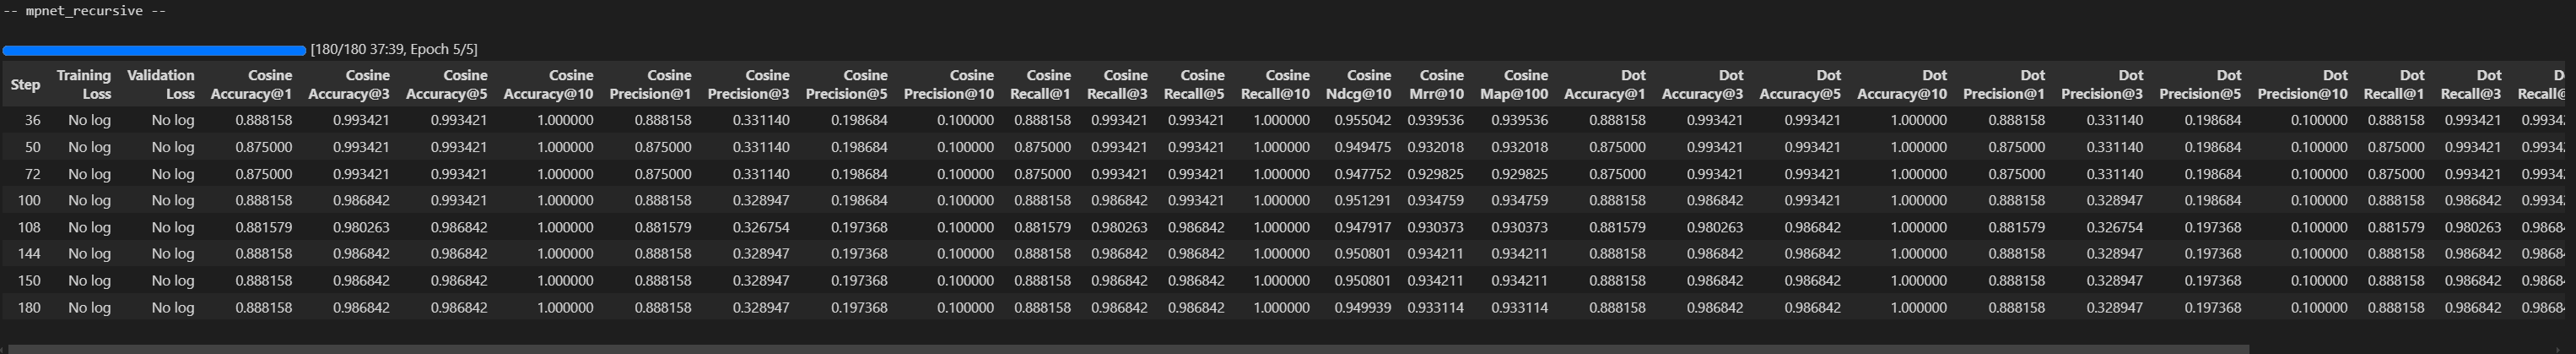

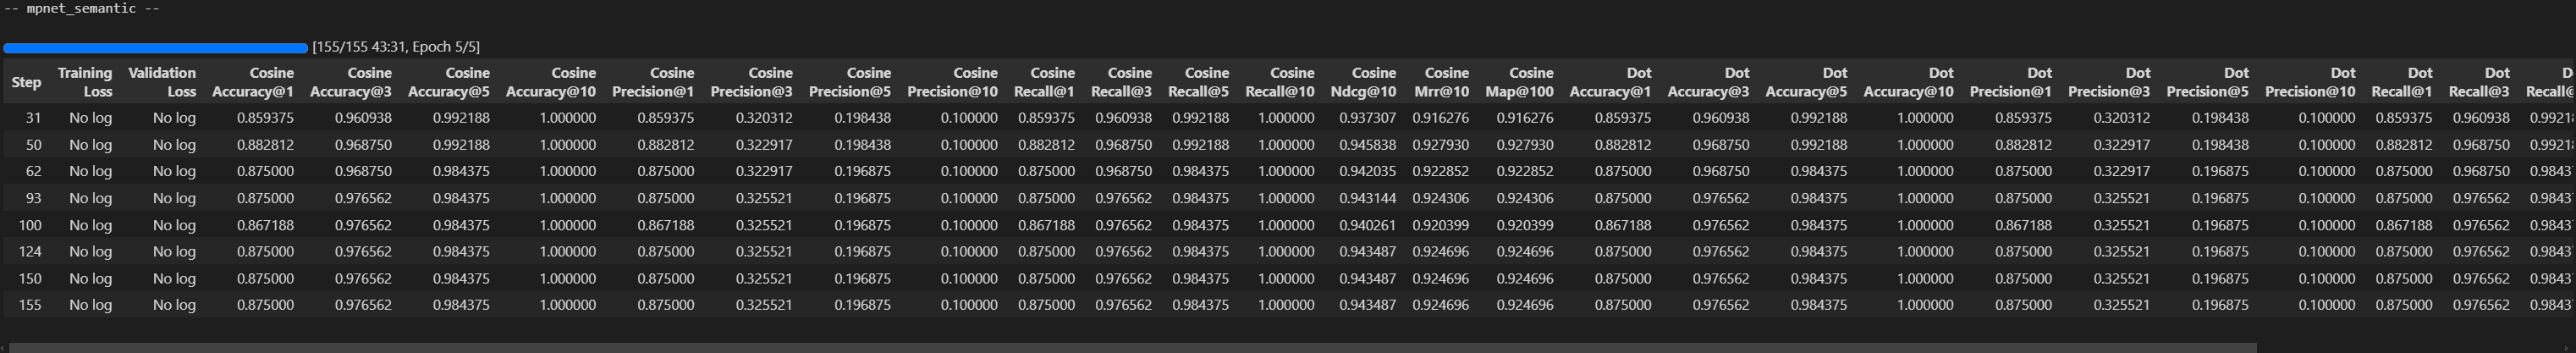

##### 🤗 Push the finetuned models to HuggingFace
[Reference](https://sbert.net/docs/package_reference/sentence_transformer/SentenceTransformer.html)

In [25]:
from huggingface_hub import notebook_login

LOGGED_IN = True   # Set False if you want to login
if not LOGGED_IN:
    notebook_login()


RERUN = True
if RERUN:
    HuggingFaceUserName = 'jet-taekyo'   # Replace with your username
    finetuned_snowflake_recursive = SentenceTransformer(model_name_or_path='finetuned_embeddings/snowflake_recursive')
    finetuned_snowflake_recursive.push_to_hub(repo_id=f"{HuggingFaceUserName}/snowflake_finetuned_recursive", exist_ok=True)

    finetuned_snowflake_semantic = SentenceTransformer(model_name_or_path='finetuned_embeddings/snowflake_semantic')
    finetuned_snowflake_semantic.push_to_hub(repo_id=f"{HuggingFaceUserName}/snowflake_finetuned_semantic", exist_ok=True)

    finetuned_mpnet_recursive = SentenceTransformer(model_name_or_path='finetuned_embeddings/mpnet_recursive')
    finetuned_mpnet_recursive.push_to_hub(repo_id=f"{HuggingFaceUserName}/mpnet_finetuned_recursive", exist_ok=True)

    finetuned_mpnet_semantic = SentenceTransformer(model_name_or_path='finetuned_embeddings/mpnet_semantic')
    finetuned_mpnet_semantic.push_to_hub(repo_id=f"{HuggingFaceUserName}/mpnet_finetuned_semantic", exist_ok=True)

##### 🤗 Apply the fine-tuned models to our RAG pipelines

In [26]:
from langchain_huggingface import HuggingFaceEmbeddings
from modules.vector_stores import get_qdrant_retriever_from_documents

# Load fine-tuned embedding models and wrap them with LangChain's HuggingFaceEmbeddings
embedding_models['snowflake_recursive'] = HuggingFaceEmbeddings(model_name='finetuned_embeddings/snowflake_recursive')
embedding_models['snowflake_semantic'] = HuggingFaceEmbeddings(model_name='finetuned_embeddings/snowflake_semantic') 
embedding_models['mpnet_recursive'] = HuggingFaceEmbeddings(model_name='finetuned_embeddings/mpnet_recursive') 
embedding_models['mpnet_semantic'] = HuggingFaceEmbeddings(model_name='finetuned_embeddings/mpnet_semantic')


# Create retrievers for each fine-tuned embedding model
for embedding_model_name, embedding_model in tqdm(embedding_models.items()):
    if 'recursive' in embedding_model_name or 'semantic' in embedding_model_name:
        retrievers[f'{embedding_model_name}_finetuned'] = get_qdrant_retriever_from_documents(
                                                documents = chunkers[embedding_model_name][1],
                                                embedding=embedding_model,
                                                collection_name=f'{embedding_model_name}_finetuned',
                                                in_memory =False,
                                                docker_container_port ="6333",
                                            )
    else: continue

# Vibe test for all retrievers
RERUN = False
if RERUN:
        inputs = {'question': "How does NIST support safe AI in line with the 2023 Executive Order?"}
        for retriever_name, retriever in retrievers.items():
                print(f"Retriever: {retriever_name}")
                config = {
                        'configurable' : {'retriever': retriever, 'rag_name': f"RAG-{retriever_name}"}
                }
                output = configurable_rag_chain.invoke(inputs, config=config)
                print(f"Q: {inputs['question']}")
                print(f"A: {output['prediction']}\n")


Some weights of BertModel were not initialized from the model checkpoint at finetuned_embeddings/snowflake_recursive and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertModel were not initialized from the model checkpoint at finetuned_embeddings/snowflake_semantic and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/7 [00:00<?, ?it/s]

##### 🤗 Deliverables of Task 4
1. Swap out your existing embedding model for the new fine-tuned version.  Provide a link to your fine-tuned embedding model on the Hugging Face Hub.
- [Finetuned 'Snowflake/snowflake-arctic-embed-m' with recursive chunking strategy](https://huggingface.co/jet-taekyo/snowflake_finetuned_recursive)
- [Finetuned 'Snowflake/snowflake-arctic-embed-m' with semantic strategy](https://huggingface.co/jet-taekyo/snowflake_finetuned_semantic)
- [Finetuned 'all-mpnet-base-v2' with recursive chunking strategy](https://huggingface.co/jet-taekyo/mpnet_finetuned_recursive)
- [Finetuned 'all-mpnet-base-v2' with semantic chunking strategy](https://huggingface.co/jet-taekyo/mpnet_finetuned_semantic)

2. How did you choose the embedding model for this application?
- As mentioned in the Deliverables of Task 2, I selected 'Snowflake/snowflake-arctic-embed-m' because it is a model we are familiar with. Additionally, I chose 'all-mpnet-base-v2' due to its popularity within the Hugging Face community.

## 👩‍💻 Task 5: Assessing Performance

##### 🤗 In Task 3, we evaluated:

1. RAG with retriever of *text-embedding-3-small* and recursive chunking
2. RAG with retriever of *text-embedding-3-small* and semantic chunking
3. RAG with retriever of *Snowflake/snowflake-arctic-embed-m* and recursive chunking
4. RAG with retriever of *Snowflake/snowflake-arctic-embed-m* and semantic chunking
5. RAG with retriever of *all-mpnet-base-v2* and recursive chunking
6. RAG with retriever of *all-mpnet-base-v2* and semantic chunking

This time, let's evaluate:

7. RAG with retriever of *Snowflake/snowflake-arctic-embed-m* fine-tuned for recursive chunking
8. RAG with retriever of *Snowflake/snowflake-arctic-embed-m* fine-tuned for semantic chunking
9. RAG with retriever of *all-mpnet-base-v2* fine-tuned for recursive chunking
10. RAG with retriever of *all-mpnet-base-v2* fine-tuned for semantic chunking

##### 🤗 What about IR (information retrieval) performances?

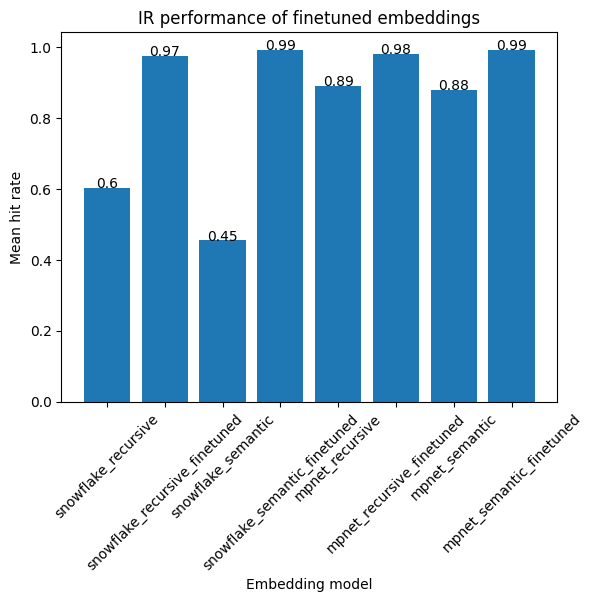

In [27]:

from modules.finetune import evaluate_IR_for_langchain_embedding_model
import pandas as pd
from modules.utils import get_bar_plot

if os.path.exists("Results/IR/IR_performances.pkl"):
    with open("Results/IR/IR_performances.pkl", "rb") as f:
        IR_performances = pickle.load(f)
else:
    os.makedirs("Results/IR", exist_ok=True)
    IR_performances = {}
    for embedding_model_name, embedding_model in tqdm(embedding_models.items()):
        if 'openai' in embedding_model_name: 
            continue
        
        if embedding_model_name == 'snowflake':
            testset_recursive =  sentence_transformer_finetuning_datasets['snowflake_recursive']['test']
            testset_semantic =  sentence_transformer_finetuning_datasets['snowflake_semantic']['test']
            IR_performances['snowflake_recursive'] = evaluate_IR_for_langchain_embedding_model(dataset = testset_recursive, embedding=embedding_model)   
            IR_performances['snowflake_semantic'] = evaluate_IR_for_langchain_embedding_model(dataset = testset_semantic, embedding=embedding_model)
        elif embedding_model_name == 'mpnet':
            testset_recursive =  sentence_transformer_finetuning_datasets['mpnet_recursive']['test']
            testset_semantic =  sentence_transformer_finetuning_datasets['mpnet_semantic']['test']
            IR_performances['mpnet_recursive'] = evaluate_IR_for_langchain_embedding_model(dataset = testset_recursive, embedding=embedding_model)   
            IR_performances['mpnet_semantic'] = evaluate_IR_for_langchain_embedding_model(dataset = testset_semantic, embedding=embedding_model)
        else:
            testset =  sentence_transformer_finetuning_datasets[embedding_model_name]['test']
            IR_performances[embedding_model_name+'_finetuned'] = evaluate_IR_for_langchain_embedding_model(dataset = testset, embedding=embedding_model)  
    with open("Results/IR/IR_performances.pkl", "wb") as f: 
        pickle.dump(IR_performances, f)



# Visualize the results
bar_plot_data = {}
for key in IR_performances:
    bar_plot_data[key] = pd.DataFrame(IR_performances[key]) ['is_hit'].mean() 
orders = ['snowflake_recursive', 'snowflake_recursive_finetuned', 'snowflake_semantic', 'snowflake_semantic_finetuned',
           'mpnet_recursive', 'mpnet_recursive_finetuned', 'mpnet_semantic', 'mpnet_semantic_finetuned']

get_bar_plot(
    data = bar_plot_data,
    title = f'IR performance of finetuned embeddings',
    xlabel='Embedding model',
    ylabel='Mean hit rate',
    orders=orders
)

##### 🤗 What about RAG performances?

  0%|          | 0/10 [00:00<?, ?it/s]

/home/jetlee/workspace/MIDTERM_TEST/Cohort_AIE4/midterm/modules/utils.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(metric.keys(), rotation=45, ha='right')
/home/jetlee/workspace/MIDTERM_TEST/Cohort_AIE4/midterm/modules/utils.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(metric.keys(), rotation=45, ha='right')
/home/jetlee/workspace/MIDTERM_TEST/Cohort_AIE4/midterm/modules/utils.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row, col].set_xticklabels(metric.keys(), rotation=45, ha='right')
/home/jetlee/workspace/MIDTERM_TEST/Cohort_AIE4/midterm/modules/utils.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

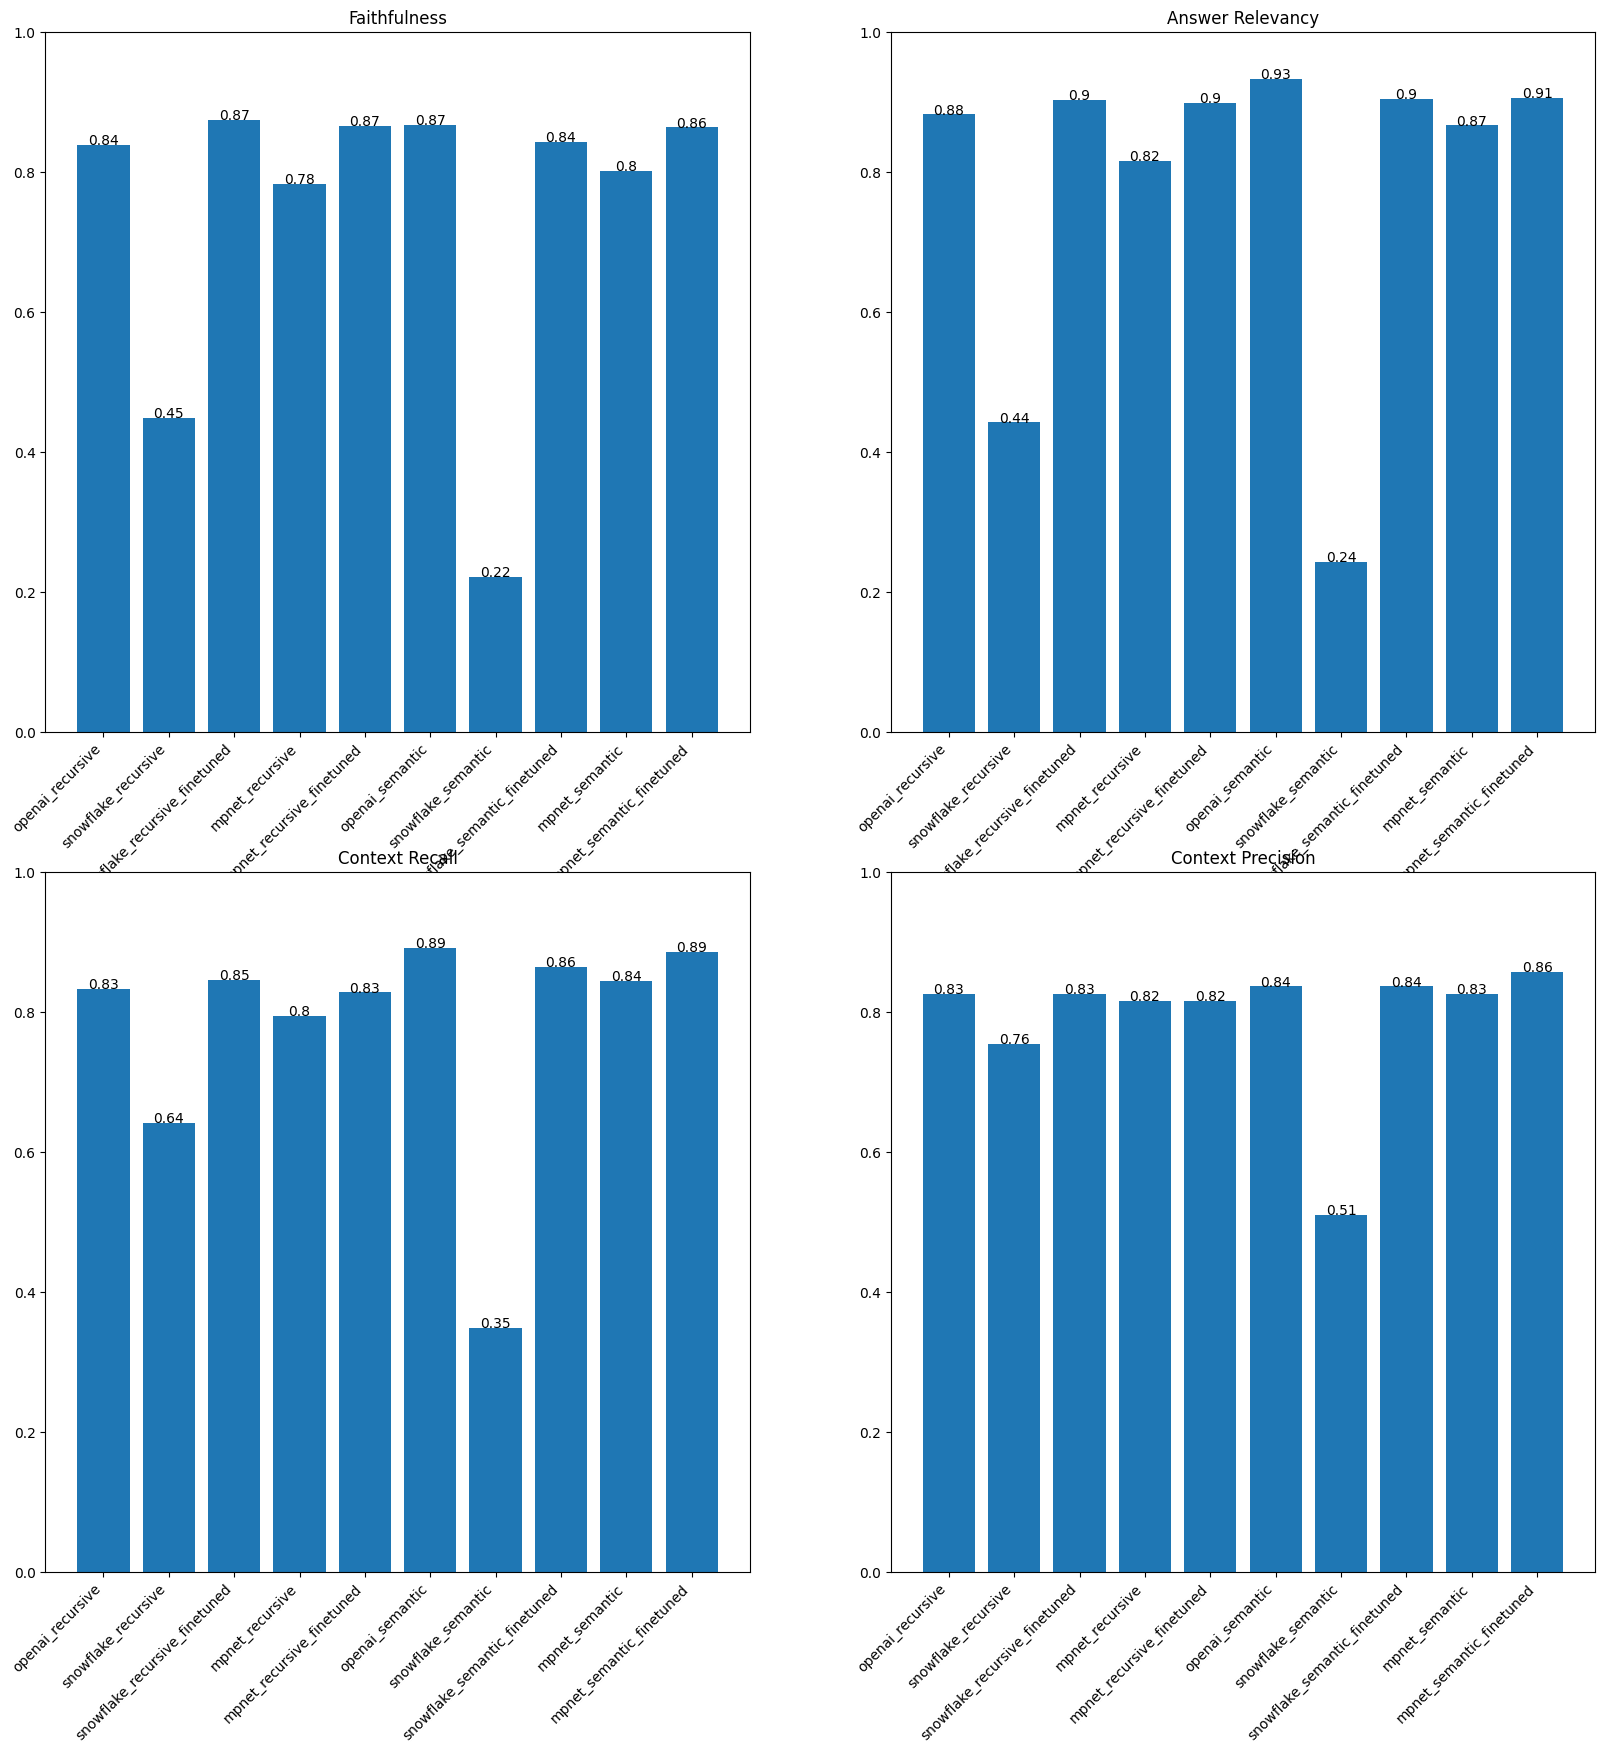

In [28]:
import pickle
from langsmith import Client
from modules.ragas_evaluation import RAGAS_e2e_evalate
from tqdm.notebook import tqdm
from modules.utils import viaulaize_results

# Download the testset back from LangSmith we have pushed. 
client = Client()
dataset_id = "3d554600-b891-41cb-9ef4-ee67b81bb323"  # Can get from LangSmith GUI 
testset = list(client.list_examples(dataset_id=dataset_id))
testset = [{'question':data.inputs['question'], 'ground_truth':data.outputs['ground_truth'] } for data in testset]


# Run each of the RAGs and evaluate them
ragas_results = {}
for file in os.listdir('Results/RAGAS_before_finetuning'):
    if file.endswith('.pkl'):
        with open(f"Results/RAGAS_before_finetuning/{file}", "rb") as f:
            ragas_results[file.split('.pkl')[0]]= pickle.load(f)

for retriever_name, retriever in tqdm(retrievers.items()):
    if 'finetuned' not in retriever_name: 
        continue
    else:
        config = {
                'configurable' : {'retriever': retriever, 'rag_name': f"RAG-{retriever_name}"}
        }
        
        if os.path.exists(f"Results/RAGAS_after_finetuning/{retriever_name}.pkl"):
            with open(f"Results/RAGAS_after_finetuning/{retriever_name}.pkl", "rb") as f:
                result = pickle.load(f)
        else:
            os.makedirs("Results/RAGAS_after_finetuning", exist_ok=True)
            result = RAGAS_e2e_evalate(configurable_rag_chain, testset, config)
            with open(f"Results/RAGAS_after_finetuning/{retriever_name}.pkl", "wb") as f:
                pickle.dump(result, f)
        
        ragas_results[retriever_name] = result


# Visualize the results
orders = [
    'openai_recursive', 'snowflake_recursive', 'snowflake_recursive_finetuned', 'mpnet_recursive', 'mpnet_recursive_finetuned',
    'openai_semantic', 'snowflake_semantic', 'snowflake_semantic_finetuned', 'mpnet_semantic', 'mpnet_semantic_finetuned',
]
df = viaulaize_results(
    ragas_results,
    orders = orders
    )

##### 🤗 Deliverables of Task 5
1. Test the fine-tuned embedding model using the RAGAS frameworks to quantify any improvements.  Provide results in a table.

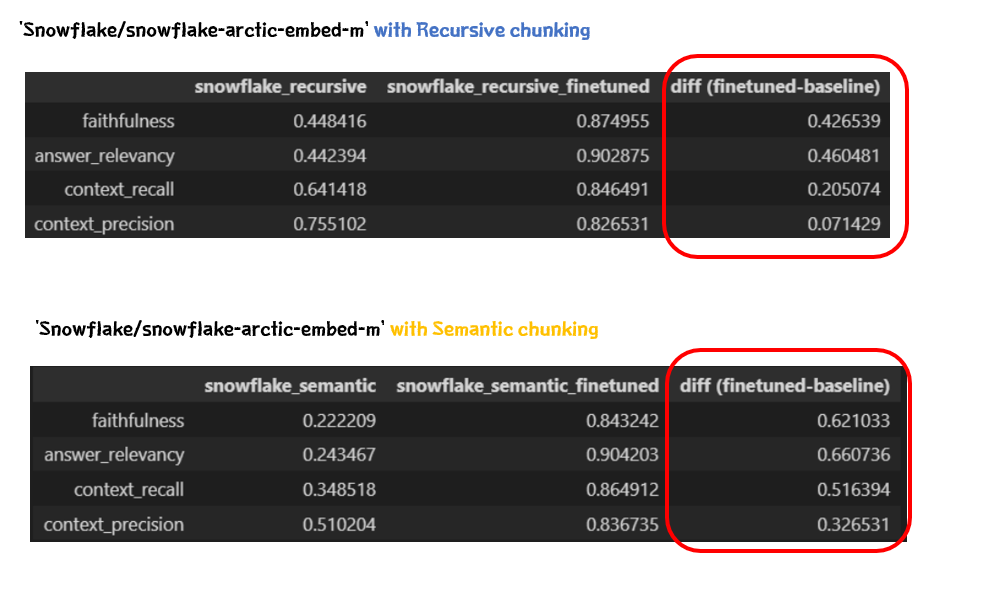

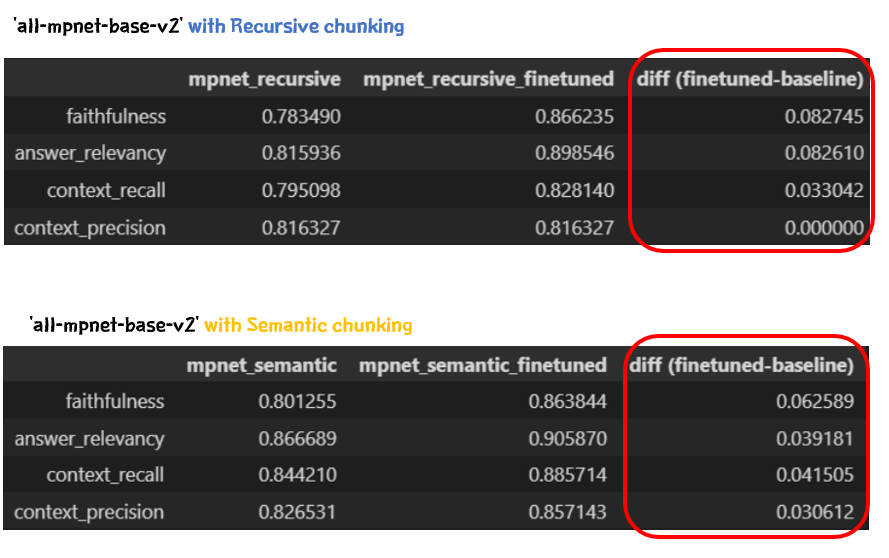

2. Test the two chunking strategies using the RAGAS frameworks to quantify any improvements. Provide results in a table. 

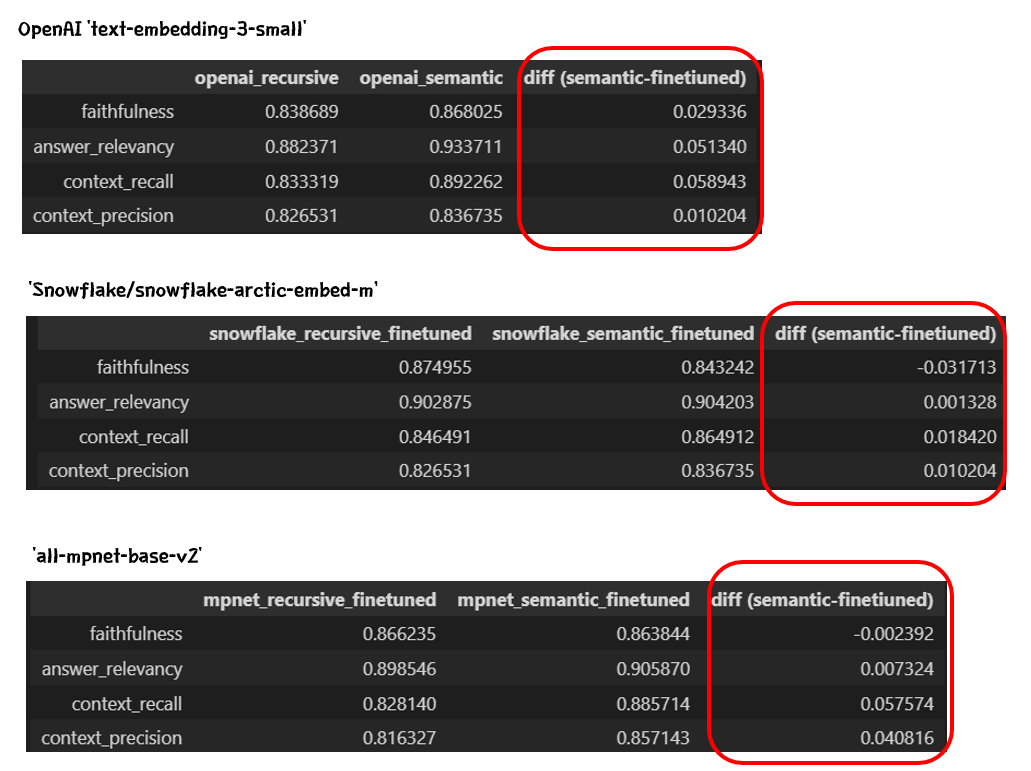


3. The AI Solutions Engineer asks you “Which one is the best to test with internal stakeholders next week, and why?”
- As far as 'finetuned' models are concerned, both open-source models, 'Snowflake/snowflake-arctic-embed-m' and 'all-mpnet-base-v2', show comparable performance to OpenAI's 'text-embedding-3-small' model. Therefore, it is more cost-effective to use one of the open-source models.

- Regarding the chunking strategy, there may not be a significant difference in performance between recursive chunking and semantic chunking. However, semantic chunking outperformed recursive chunking in three out of four categories (answer relevancy, context recall, context precision). Hence, I recommend using semantic chunking.


## 👩‍💻 Task 6: Managing Your Boss and User Expectation

You are the SVP of Technology.  Given the work done by your team so far, you're now sitting down with the AI Solutions Engineer.  You have tasked the solutions engineer to test out the new application with at least 50 different internal stakeholders over the next month.

##### 🤗 Deliverables of Task 6
1. What is the story that you will give to the CEO to tell the whole company at the launch next month?
-  Our AI team has made remarkable progress in developing a domain-specific model that rivals the performance of some of the best in the industry, including OpenAI’s proprietary model.

- By intentionally focusing on a specific domain and allowing some level of overfitting, we were able to fine-tune our model to meet the precise needs of our users. This strategic approach has enabled us to achieve exceptional accuracy and relevance in our AI solutions.


2. There appears to be important information not included in our build, for instance, the 270-day update on the 2023 executive order on Safe, Secure, and Trustworthy AI. How might you incorporate relevant white-house briefing information into future versions? 
- CI/CD Setup: Establish a robust Continuous Integration and Continuous Deployment (CI/CD) pipeline for the Retrieval-Augmented Generation (RAG) system. This pipeline will enable us to:

    - Regular Updates: Schedule regular updates of the vector database and embedding models to include new information from sources such as White House briefings, policy changes, and other relevant documents.
    - On-Demand Updates: Allow for on-demand updates to quickly incorporate any urgent or high-priority information.

- Automate Data Ingestion and Processing
    - Automated Data Sources: Set up automated ingestion of relevant data sources, such as government websites, official briefings, and trusted news outlets.
    - Data Preprocessing: Implement preprocessing scripts to clean, categorize, and extract key information from these sources before integrating it into the vector database.